# Setup

In [1]:
# Python 3 compatability
from __future__ import division, print_function

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
import math
from numpy import linalg
import scipy
from scipy import stats

# plotting
import matplotlib
from matplotlib import pyplot as plt

# fits data
from astropy.io import fits

# inline plotting
%matplotlib inline

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'axes.titlepad': '15.0'})
rcParams.update({'axes.labelpad': '15.0'})
rcParams.update({'font.size': 30})

# Star with 2 Bands: Forced Photometry

Grab data.

In [3]:
nruns, ncolors, ntrials = 9, 4, 100000
sigclip = 5.

# effective area
psfwidth, noise = 2., 1.
aeff = 4. * np.pi * psfwidth**2
err = np.sqrt(aeff * noise**2)

# true values
f, f2, ferr, ftrials = np.zeros((4, nruns, ncolors))

# extract data
flux, fluxerr, x, y = np.zeros((4, nruns, ncolors, ntrials))
flux_det, fluxerr_det = np.zeros((2, nruns, ncolors, ntrials))
for i in range(nruns):
    for j in range(ncolors):
        fname = 'data/force_phot/run{0}.fits'.format(i * ncolors + j)  # run
        if os.path.isfile(fname):
            hdul = fits.open(fname)
            # grab true values
            f[i, j] = hdul[0].header['TRUEFLUX']  # true flux
            f2[i, j] = f[i, j] * hdul[0].header['TRUECOLR']  # second true flux
            psfwidth = hdul[0].header['PSFWIDTH']  # Gaussian PSF width
            noise = hdul[0].header['NOISE']  # iid Gaussian noise
            aeff = 4. * np.pi * psfwidth**2  # effective area
            ferr[i, j] = np.sqrt(aeff * noise**2)  # true error
            # grab trials
            data = hdul[1].data
            flux[i, j] = data['Flux2']  # fluxes
            fluxerr[i, j] = data['Flux2err']  # flux errors
            x[i, j], y[i, j] = data['X'], data['Y']  # positions
            flux_det[i, j] = data['Flux']  # detection band flux
            fluxerr_det[i, j] = data['FluxErr']  # detection band error
            # clip suspicious trials
            pos = np.c_[x[i, j], y[i, j]]
            cinv = np.linalg.inv(np.cov(pos, rowvar=False))  # inv-cov
            sqdist = np.array([np.dot(np.dot(p, cinv), p) 
                               for p in pos])  # normalized distance
            sel = (sqdist <= sigclip**2) & (flux_det[i, j] / fluxerr_det[i, j] > 0.2)  # clip outliers
            flux[i, j, ~sel], fluxerr[i, j, ~sel] = np.nan, np.nan
            x[i, j, ~sel], y[i, j, ~sel] = np.nan, np.nan
            flux_det[i, j, ~sel], fluxerr_det[i, j, ~sel] = np.nan, np.nan
            ftrials[i, j] = len(sel)
        else:
            print(fname + ' not found.')

In [4]:
# define relevant quantities
snr = f / ferr  # true SNR
favg, fstd = np.nanmean(flux, axis=2), np.nanstd(flux, axis=2)
fbias_avg = (favg - f2) / f2  # fractional bias
fbias_err = fstd / f2 / np.sqrt(ftrials)  # uncertainty
favg_det, fstd_det = np.nanmean(flux_det, axis=2), np.nanstd(flux_det, axis=2)
fbias_avg_det = (favg_det - f) / f  # fractional bias
fbias_err_det = fstd_det / f / np.sqrt(ftrials)  # uncertainty
cbias_avg = np.nanmedian(-2.5 * np.log10(flux_det / flux), axis=2) + 2.5 * np.log10(f / f2)
cbias_sel = np.isnan(-2.5 * np.log10(flux_det / flux)).sum(axis=2) < 0.02 * ntrials
cbias_std = np.nanstd(-2.5 * np.log10(flux_det / flux), axis=2) / np.sqrt(ftrials)

/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()


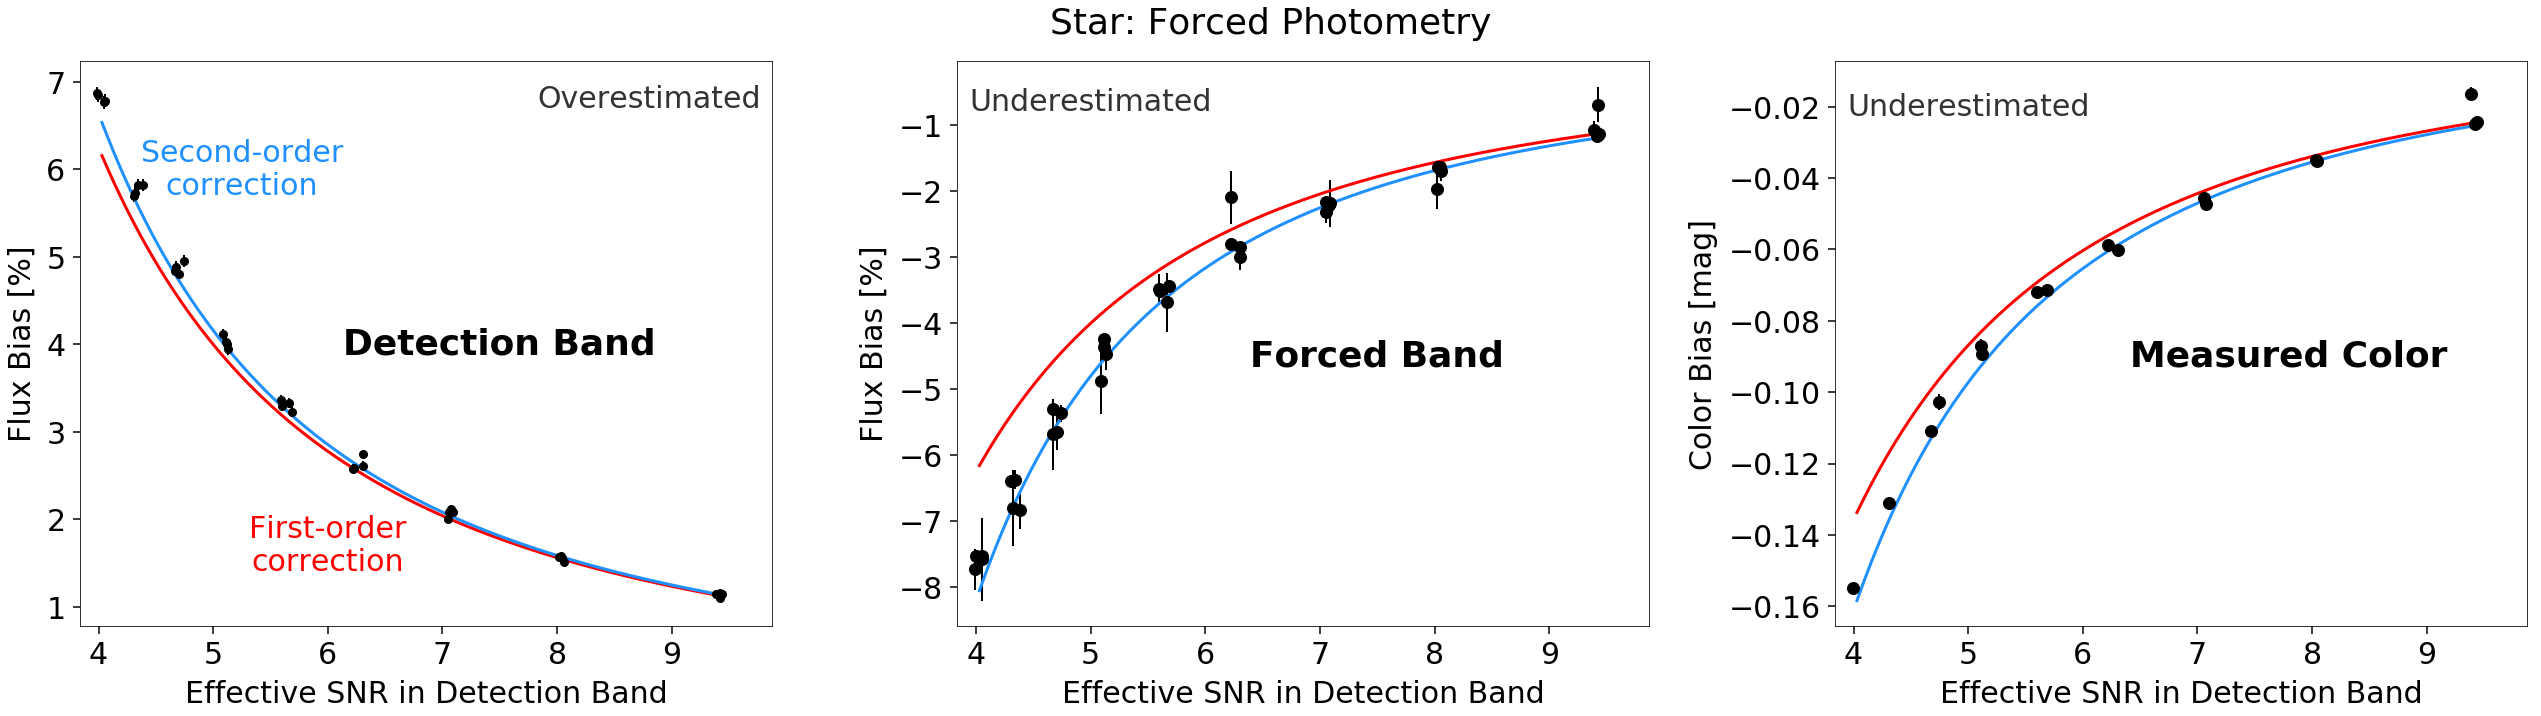

In [5]:
np.random.seed(9971)  # declare seed
snr_grid = np.linspace(np.nanmin(snr), np.nanmax(snr), 1000)
jitter = np.random.uniform(-0.05, 0.05, size=snr.shape)

# plot flux bias + variance
plt.figure(figsize=(36, 10))
plt.suptitle('Star: Forced Photometry', y=1.02)

# flux (band 1)
plt.subplot(1, 3, 1)
plt.errorbar((snr + jitter).flatten(),
             fbias_avg_det.flatten() * 100., 
             yerr=fbias_err_det.flatten() * 100.,
             marker='o', color='black', 
             linestyle='none', markersize=8,
             elinewidth=2)  # avg fractional bias
plt.plot(snr_grid, snr_grid**-2 * 100., 
         linestyle='-', color='red', 
         label='1st-order', lw=3)  # 1st-order correction
plt.plot(snr_grid, (snr_grid**-2 + snr_grid**-4) * 100., 
         linestyle='-', color='dodgerblue',
         label='2nd-order', lw=3)  # 2nd-order correction
# label
plt.text(6, 1.7, 'First-order\ncorrection', 
         horizontalalignment='center', verticalalignment='center',
         color='red')
plt.text(5.25, 6, 'Second-order\ncorrection', 
         horizontalalignment='center', verticalalignment='center',
         color='dodgerblue')
# prettify
plt.text(8.8, 6.8, 'Overestimated',
         horizontalalignment='center', verticalalignment='center',
         color='black', alpha=0.8)
plt.text(7.5, 4.0, 'Detection Band', weight='bold', fontsize='large',
         horizontalalignment='center', verticalalignment='center',
         color='black')
plt.xlabel(r'Effective SNR in Detection Band', labelpad=10)
plt.ylabel(r'Flux Bias [%]', labelpad=10)
plt.xlim(np.nanmin(snr) / 1.05, np.nanmax(snr) * 1.05)
plt.tight_layout()

# flux (band 2)
plt.subplot(1, 3, 2)
plt.errorbar((snr + jitter).flatten(), fbias_avg.flatten() * 100., 
             yerr=fbias_err.flatten() * 100.,
             marker='o', color='black', 
             linestyle='none', markersize=12,
             elinewidth=2)  # avg fractional bias
plt.plot(snr_grid, -snr_grid**-2 * 100., 
         linestyle='-', color='red', 
         label='1st-order', lw=3)  # 1st-order correction
plt.plot(snr_grid, -(snr_grid**-2 + 5 * snr_grid**-4) * 100., 
         linestyle='-', color='dodgerblue',
         label='2nd-order', lw=3)  # 2nd-order correction
# prettify
plt.text(5.0, -0.65, 'Underestimated',
         horizontalalignment='center', verticalalignment='center',
         color='black', alpha=0.8)
plt.text(7.5, -4.5, 'Forced Band', weight='bold', fontsize='large',
         horizontalalignment='center', verticalalignment='center',
         color='black')
plt.xlabel(r'Effective SNR in Detection Band', labelpad=10)
plt.ylabel(r'Flux Bias [%]', labelpad=10)
plt.xlim(np.nanmin(snr) / 1.05, np.nanmax(snr) * 1.05)
plt.tight_layout()

# color (band 1 - band 2)
plt.subplot(1, 3, 3)
plt.errorbar((snr + jitter)[cbias_sel], cbias_avg[cbias_sel], 
             yerr=cbias_std[cbias_sel],
             marker='o', color='black', 
             linestyle='none', markersize=12,
             elinewidth=2)  # avg fractional bias
plt.plot(snr_grid, 2 * snr_grid**-2 * -2.5 / np.log(10),
         linestyle='-', color='red', 
         label='1st-order', lw=3)  # 1st-order correction
plt.plot(snr_grid, (2 * snr_grid**-2 + 6 * snr_grid**-4) * -2.5 / np.log(10),
         linestyle='-', color='dodgerblue', 
         label='2nd-order', lw=3)  # 1st-order correction
# prettify
plt.text(5.0, -0.02, 'Underestimated',
         horizontalalignment='center', verticalalignment='center',
         color='black', alpha=0.8)
plt.text(7.8, -0.09, 'Measured Color', weight='bold', fontsize='large',
         horizontalalignment='center', verticalalignment='center',
         color='black')
plt.xlabel(r'Effective SNR in Detection Band', labelpad=10)
plt.ylabel(r'Color Bias [mag]', labelpad=10)
plt.xlim(np.nanmin(snr) / 1.05, np.nanmax(snr) * 1.05)
plt.tight_layout()

# save figure
plt.savefig('plots/star_forced.png', bbox_inches='tight')